#### <b>Download the Dataset</b>

- data path :
https://github.com/LimHaY/2023_AI1_team9/releases/download/custom_dataset/custom_family_dataset.zip

In [2]:
%%capture
!wget https://github.com/LimHaY/2023_AI1_team9/releases/download/custom_dataset/custom_family_dataset.zip -O custom_family_dataset.zip
!unzip custom_family_dataset.zip -d ./custom_family_dataset

#### <b>Load Libraries</b>

In [3]:
# 얼굴영역 인식 라이브러리 설치
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 73.5 MB/s eta 0:00:00


In [4]:
import random
import os
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from facenet_pytorch import InceptionResnetV1

In [5]:
"""
> [Function] Parse the metadata.
* family_list = ["F0001", "F0002", ...]
* family_to_person_map["F0001"] = ["D", "GM", "M"]
* person_to_image_map["F0001_D"] = [
    "F0001_AGE_D_18_a1.jpg",
    "F0001_AGE_D_18_a2.jpg",
    ...
]
"""
# metadata 를 parsing 하는 함수 
def parsing(metadata):
    family_set = set()
    family_to_person_map = dict()
    person_to_image_map = dict()
    # iterate all rows in the metadata file
    for idx, row in metadata.iterrows():
        family_id = row["family_id"]
        person_id = row["person_id"]
        key = family_id + "_" + person_id
        image_path = row["image_path"]
        if family_id not in family_set:
            family_set.add(family_id)
            family_to_person_map[family_id] = []
        if person_id not in family_to_person_map[family_id]:
            family_to_person_map[family_id].append(str(person_id))    
            person_to_image_map[key] = []
        person_to_image_map[key].append(image_path) # save all image paths
    family_list = list(family_set)
    return family_list, family_to_person_map, person_to_image_map

#### <b>Configuration</b>

In [6]:
batch_size = 64
lr = 0.001
log_step = 20
weights = [6, 5, 2]
weight_map = {
    'D': 0,
    'D2': 0,
    'D3': 0,
    'D4': 0,
    'S': 0,
    'S2': 0,
    'S3': 0,
    'S4': 0,
    'F': 1,
    'M': 1,
    'GF': 2,
    'GM': 2
}

#### <b>Load Datasets</b>

* Training dataset
  * (F0001 ~ F0727) folders have 22,427 images.
* Validation dataset
  * (F0728 ~ F0812) folders have 2,712 images.
* Test dataset
  * (F0813 ~ F0900) folders have 2,670 images.

In [7]:
# train data 반환하는 class : 비교할 이미지(img1,img2), label, 사전 학습된 weight 반환
class TrainDataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # process the meta data
        family_list, family_to_person_map, person_to_image_map = parsing(meta_data)
        self.family_list = family_list
        self.family_to_person_map = family_to_person_map
        self.person_to_image_map = person_to_image_map

    def __len__(self):
        return len(self.meta_data) * 2
               
    def __getitem__(self, idx):
        # positive samples (family)
        if idx % 2 == 0:
            # choice a single family
            family_id = random.choice(self.family_list)
            # choice 2 different person in a single family
            p1, p2 = random.sample(self.family_to_person_map[family_id], 2) 
            key1 = family_id + "_" + p1
            key2 = family_id + "_" + p2
            label = 1
        # negative samples (not family)
        else:
            # choice 2 different familiy
            f1, f2 = random.sample(self.family_list, 2)
            # choice a person in each family
            p1 = random.choice(self.family_to_person_map[f1])
            p2 = random.choice(self.family_to_person_map[f2])
            key1 = f1 + "_" + p1
            key2 = f2 + "_" + p2
            label = 0

        path1 = random.choice(self.person_to_image_map[key1])
        path2 = random.choice(self.person_to_image_map[key2])

        img1 = Image.open(os.path.join(self.image_directory, path1))
        img2 = Image.open(os.path.join(self.image_directory, path2))

        g1 = path1.split('_')[2]
        g2 = path2.split('_')[2]
        weight = weights[abs(weight_map[g1] - weight_map[g2])]
        
        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)
        
        return img1, img2, label, weight

In [8]:
# 평가 data 반환하는 class : 비교할 이미지(img1,img2), label, 사전 학습된 weight반환
class EvaluationDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        self.positive_folder = os.path.join(image_directory, "positive")
        self.negative_folder = os.path.join(image_directory, "negative")
        self.positive_list = os.listdir(self.positive_folder)
        self.negative_list = os.listdir(self.negative_folder)
        self.transform = transform

    def __len__(self):
        return len(self.positive_list) + len(self.negative_list)

    def __getitem__(self, idx):
        # positive samples (family)
        if idx % 2 == 0:
            result_folder = os.path.join(self.positive_folder, self.positive_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 1
        # negative samples (not family)
        else:
            result_folder = os.path.join(self.negative_folder, self.negative_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 0

        img1 = Image.open(os.path.join(result_folder, file1))
        img2 = Image.open(os.path.join(result_folder, file2))

        g1 = file1.split('_')[2]
        g2 = file2.split('_')[2]
        weight = weights[abs(weight_map[g1] - weight_map[g2])]

        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)

        return img1, img2, label, weight

In [9]:
# 데이터로더 정의

train_meta_data_path = "./custom_family_dataset/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_family_dataset/train_images"

val_image_directory = "./custom_family_dataset/fixed_val_dataset"
test_image_directory = "./custom_family_dataset/fixed_test_dataset"

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = TrainDataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = EvaluationDataset(val_image_directory, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = EvaluationDataset(test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

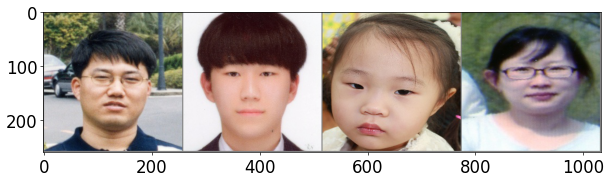

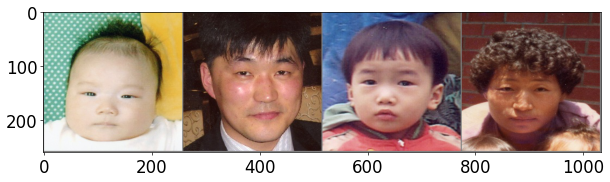

tensor([1, 1, 0, 1])


In [10]:
# 데이터 샘플 확인

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
img1, img2, label, weight = next(iterator)
out = torchvision.utils.make_grid(img1[:4])
imshow(out)
out = torchvision.utils.make_grid(img2[:4])
imshow(out)
print(label[:4]) # 1: family, 0: not family

#### <b>Define Models</b>
- https://tyami.github.io/deep%20learning/Siamese-neural-networks/ 참조

In [11]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = InceptionResnetV1(pretrained='vggface2')  #  vggface2 를 이용하여 얼굴영역 검출
        self.emb_dim = 512

        self.last = nn.Sequential(
            nn.Linear(4 * self.emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, input1, input2):
        emb1 = self.encoder(input1)
        emb2 = self.encoder(input2)
        
        x1 = torch.pow(emb1, 2) - torch.pow(emb2, 2)
        x2 = torch.pow(emb1 - emb2, 2)
        x3 = emb1 * emb2
        x4 = emb1 + emb2
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.last(x)

        return x

#### <b>Train a Model</b>

In [12]:
net = SiameseNet().cuda()
net = torch.nn.DataParallel(net)

criterion = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, patience=5)
sigmoid = nn.Sigmoid()

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [13]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    net.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        output = net(img1, img2)
        preds = sigmoid(output) >= 0.5
        loss = criterion(output, label)
        loss = loss * weight
        loss = torch.mean(loss)

        loss.backward()
        optimizer.step()
        
        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    net.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        with torch.no_grad():
            output = net(img1, img2)
            preds = sigmoid(output) >= 0.5
            loss = criterion(output, label)
            loss = loss * weight
            loss = torch.mean(loss)

        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [14]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## 런타임 연결 끊김 해제 
while True:pass


In [ ]:
saved_path = "/content/gdrive/MyDrive/Colab Notebooks/AI1"  # 모델 저장할 경로
num_epochs = 20
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))
    scheduler.step(val_loss)

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(net.state_dict(), f'{saved_path}/best_checkpoint_epoch_{epoch + 1}.pth')
    torch.save(net.state_dict(), f'{saved_path}/checkpoint_epoch_{epoch + 1}.pth')

torch.save(net.state_dict(), f'{saved_path}/last_checkpoint_epoch_{num_epochs}.pth')

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.054710103571414946, running train accuracy: 0.48750001192092896
[Batch: 40] running train loss: 0.05492747770622373, running train accuracy: 0.49140626192092896
[Batch: 60] running train loss: 0.05490036600579818, running train accuracy: 0.4997396171092987
[Batch: 80] running train loss: 0.05503848637454212, running train accuracy: 0.4957031309604645
[Batch: 100] running train loss: 0.054775905422866346, running train accuracy: 0.5059375166893005
[Batch: 120] running train loss: 0.05481659152234594, running train accuracy: 0.5071614980697632
[Batch: 140] running train loss: 0.05476273452597005, running train accuracy: 0.5108258724212646
[Batch: 160] running train loss: 0.05466024063061923, running train accuracy: 0.51171875
[Batch: 180] running train loss: 0.05462860870692465, running train accuracy: 0.5142361521720886
[Batch: 200] running train loss: 0.054471604712307456, running train accuracy: 0.5163280963897705
[Batch: 220] ru

In [1]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

NameError: ignored

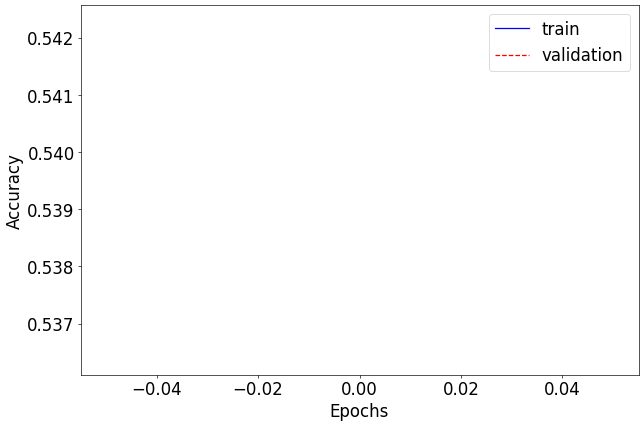

In [ ]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

#### <b>Final Test</b>

In [18]:
saved_path = "/content/gdrive/MyDrive/Colab Notebooks/AI1"  # 모델 저장할 경로
best_epoch = 7
net.load_state_dict(torch.load(f'{saved_path}/best_checkpoint_epoch_' + str(best_epoch + 1) + '.pth'))

def test():
    start_time = time.time()
    net.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        with torch.no_grad():
            output = net(img1, img2)
            preds = sigmoid(output) >= 0.5
            loss = criterion(output, label)
            loss = loss * weight
            loss = torch.mean(loss)

        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

test()

[Batch: 1] running test loss: 0.04845619201660156, running test accuracy: 0.703125
[Batch: 20] running test loss: 0.05810017604380846, running test accuracy: 0.614062488079071
[Batch: 40] running test loss: 0.05859205834567547, running test accuracy: 0.6117187738418579
[Batch: 60] running test loss: 0.05896817687898874, running test accuracy: 0.6075521111488342
[Batch: 80] running test loss: 0.059435845958068965, running test accuracy: 0.607617199420929
[Batch: 100] running test loss: 0.05959237080067396, running test accuracy: 0.6087499856948853
[Batch: 120] running test loss: 0.058908607624471185, running test accuracy: 0.6132813096046448
[Batch: 140] running test loss: 0.058898171250309266, running test accuracy: 0.61328125
test loss: 0.05910905675888062, accuracy: 0.6151999831199646
elapsed time: 125.47223091125488


(0.05910905675888062, 0.6151999831199646)

#### <b>Using Ensembles</b>

In [ ]:
# checkpoints = [15, 16, 17, 18, 19]
checkpoints = [1]

models = []
for checkpoint in checkpoints:
    model = SiameseNet().cuda()
    model = nn.DataParallel(model)
    state_dict = torch.load(f"{saved_path}/checkpoint_epoch_{checkpoint}.pth")
    model.load_state_dict(state_dict)
    
    models.append(model)

In [ ]:
def test_ensembles():
    start_time = time.time()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        img1, img2, label, weight = batch
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.float().view(-1, 1).cuda()

        preds = 0
        losses = 0
        for model in models:
            model.eval()
            with torch.no_grad():
                output = model(img1, img2)
                preds += sigmoid(output) / len(models)
                loss = criterion(output, label)
                loss = loss * weight
                loss = torch.mean(loss)
                losses += loss / len(models)

        pred = preds >= 0.5
        total += label.shape[0]
        running_loss += losses.item()
        running_corrects += torch.sum(pred == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

test_ensembles()

[Batch: 1] running test loss: 0.05640115588903427, running test accuracy: 0.59375
[Batch: 20] running test loss: 0.057562794908881186, running test accuracy: 0.54296875
[Batch: 40] running test loss: 0.057389537803828716, running test accuracy: 0.548828125
[Batch: 60] running test loss: 0.05750474644203981, running test accuracy: 0.5458333492279053
[Batch: 80] running test loss: 0.05764713655225932, running test accuracy: 0.5482422113418579
[Batch: 100] running test loss: 0.057710480876266956, running test accuracy: 0.5412499904632568
[Batch: 120] running test loss: 0.05778773929923773, running test accuracy: 0.5393229722976685
[Batch: 140] running test loss: 0.057668855333966866, running test accuracy: 0.5430803894996643
test loss: 0.058048321175575256, accuracy: 0.5411999821662903
elapsed time: 125.55152773857117


(0.058048321175575256, 0.5411999821662903)

#### <b>Custom Test</b>

In [ ]:
!git clone https://github.com/ndb796/korean_face_age_classification

Cloning into 'korean_face_age_classification'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (83/83), done.
remote: Total 85 (delta 30), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (85/85), 4.22 MiB | 7.32 MiB/s, done.


In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ERO90Zk8tGlGn4nM1VM6UpkBuJV5rdKmYU4ia7wRp-K4CA?download=1 -O saved_best_checkpoint_epoch.pth

In [ ]:
net = SiameseNet().cuda()
net = nn.DataParallel(net)
state_dict = torch.load(f"./saved_best_checkpoint_epoch.pth")
net.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
test()

[Batch: 1] running test loss: 0.0650169849395752, running test accuracy: 0.59375
[Batch: 20] running test loss: 0.06466656439006328, running test accuracy: 0.578125
[Batch: 40] running test loss: 0.06305804178118705, running test accuracy: 0.6019531488418579
[Batch: 60] running test loss: 0.06337643197427194, running test accuracy: 0.6015625596046448
[Batch: 80] running test loss: 0.0633515341207385, running test accuracy: 0.598437488079071
[Batch: 100] running test loss: 0.06403283342719078, running test accuracy: 0.5921874642372131
[Batch: 120] running test loss: 0.0644089635151128, running test accuracy: 0.5919271111488342
[Batch: 140] running test loss: 0.06413484561656202, running test accuracy: 0.5938616394996643
test loss: 0.06407643764019012, accuracy: 0.5960999727249146
elapsed time: 124.7668685913086


(0.06407643764019012, 0.5960999727249146)

In [ ]:
images = []
image_cnt = 10

for i in range(1, image_cnt + 1):
    filename = f'example_{i}.png'
    image = Image.open('korean_face_age_classification/images/' + filename).convert('RGB')
    image = test_transform(image).unsqueeze(0).cuda()
    images.append(image)

In [ ]:
from itertools import combinations


possibles = list(combinations(images, 2))

for possible in possibles:
    one, two = possible

    with torch.no_grad():
        output = net(one, two)
        pred = sigmoid(output) >= 0.5

    result = pred[0][0].item()
    print(f"가족 관계 예측 결과: {result}")
    # print(f"가족 관계 예측 결과: {result} ({sigmoid(output)[0][0].item()})%")
    out = torchvision.utils.make_grid(torch.stack((one[0], two[0])))
    imshow(out.cpu())